In this project, I have coded an entire L-layer Deep Neural Network framework with multi-class classification capability using just the numpy library for major computations. This project was aimed at understanding and implementing the machinery behind the basic deep neural network architecture. Some of this work has been inspired from Andrew Ng's Deep Learning Specialization which I recently completed.

First we start by importing the necessary python libraries.

In [5]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import h5py
import pickle

We shall test our custom designed network on two datasets.
  1) MNIST dataset
  2) cat vs non-cat dataset

In [6]:
def load_catdata():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [7]:
# load cat vs noncat data
x_train, y_train, x_test, y_test, classes = load_catdata()
y_train = y_train.T.reshape([-1])
y_test = y_test.T.reshape([-1])

In [8]:
# load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We shall now define and code all our primary and helper functions which shall implement the DNN.

In [9]:
def show_image(data,img_no):
    plot = plt.imshow(data[img_no], cmap=plt.get_cmap('gray'))
    return

def flatten_and_normalize(image_dataset):
    """
    function to reshape n images (tensor) into a n column vectors (length*width,n) dimensional matrix.
    """
    new_data = image_dataset.reshape(image_dataset.shape[0], -1).T
    new_data = new_data / 255
    return new_data
    
def sigmoid(x, gradient=False):
    """
    function for finding the sigmoid of a linear activation value 'Z' when argument gradient = False 
    or the derivative of activated value 'A' when argument gradient = True
    """
    if gradient == False:
        # Here input x = Z (X.W + b)
        return 1/(1+np.exp(-x))
    else:
        # Here  input x = A (g(z))
        return x*(1-x)

def relu(x, gradient=False):
    """
    function for finding the relu activation of a linear activation value 'Z' when argument gradient = False 
    or the derivative of relu activated value 'A' when argument gradient = True
    """
    if gradient == False:
        # Here input x = Z (X.W + b)
        return np.maximum(0,x)
        #return np.tanh(z)
    else:
        # Here input x = A (g(z))
        return np.ceil(np.minimum(np.maximum(0,x),1))
        #return (1 - np.power(z, 2))
        
def tanh(x, gradient = False):
    """
    function for finding the tanh activation of a linear activation value 'Z' when argument gradient = False 
    or the derivative of tanh activated value 'A' when argument gradient = True
    """
    if gradient == False:
        # Here input x = Z (X.W + b)
        return np.tanh(x)
    else:
        # Here input x = A (g(z))
        return (1 - np.power(x, 2))
    
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)
    
def init_param(Y, n_input, n_hiddens = [3]):
    """
    function to initialize weight and bias parameters
    """
    n_out = Y.shape[0]
    n_hiddens.append(n_out)
    n_layers = [n_input] + n_hiddens
    params = {}
    for i in range(1,len(n_layers)):
        params['W'+str(i)] = np.random.randn(n_layers[i],n_layers[i-1])/np.sqrt(n_layers[i-1]) 
        params['b'+str(i)] = np.zeros((n_layers[i],1))
    return params

def forward_prop(X,params,activation = 'relu'):
    """
    function implementing one forward pass accross the network
    Returns the sigmoid activations of the output layer. 
    """   
    n_layers = len(params)//2 
    memory = {}
    A = X
   
    # forward prop for input and hidden layers
    for i in range(1,n_layers):
        memory['A'+str(i-1)] = A
        # calculate Z = W.X
        W = params['W'+str(i)]
        b = params['b'+str(i)]
        Z = np.dot(W,A)+ b
        # adding Z to memory cache for backpropagation
        memory['Z'+str(i)] = Z
        memory['W'+str(i)] = W
        memory['b'+str(i)] = b
        if activation == 'relu':
            # calculate the activation of Z
            A = relu(Z)
        elif activation == 'tanh':
            # calculate the activation of Z
            A = tanh(Z)
    
    #forward prop for output layer
    memory['A'+str(n_layers-1)] = A
    W = params['W'+str(n_layers)]
    b = params['b'+str(n_layers)]
    Z = np.dot(W,A)+ b
    memory['Z'+str(n_layers)] = Z
    memory['W'+str(n_layers)] = W
    memory['b'+str(n_layers)] = b
    # calculate the activation of output layer
    A = softmax(Z)
    return A,memory 

def softmax_loss(activation,y):
    """
    function to calculate cross-entropy loss of activation matrix w.r.t a y-matrix
    """
    m = y.shape[1]
    return (-1/m)*np.sum(y*np.log(activation))

def back_prop(out_activation,Y,cache,activation = 'relu'):
    """
    function implementing back propagation accross the network
    Returns gradients of W and b vectors w.r.t the cross-entropy loss. 
    """  
    n_layers = len(cache)//4
    grads = {}
    m = Y.shape[1]
    
    ## computing gradients for output layer
    # computing dL/dZ for output layer
    dLdZ = out_activation - Y
    
    # computing dL/dW for output layer and entering into grads dictionary
    A_prev = cache['A'+str(n_layers-1)]
    dLdW = (np.dot(dLdZ,A_prev.T))/m
    grads['dW'+str(n_layers)] = dLdW
    
    # computing dL/db for output layer and entering into grads dictionary
    dLdb = (np.sum(dLdZ,axis = 1,keepdims = True))/m
    grads['db'+str(n_layers)] = dLdb
    
    ## computing gradients for hidden layers
    for i in reversed(range(1,n_layers)):
        # computing dL/dZ
        W = cache['W'+str(i+1)]
        A = cache['A'+str(i)]
        if activation == 'relu':
            dLdZ = np.dot(W.T,dLdZ) * relu(A, gradient = True)
        elif activation == 'tanh':
            dLdZ = np.dot(W.T,dLdZ) * tanh(A, gradient = True)
        
        # computing dL/dW and entering into grads dictionary
        A_prev = cache['A'+str(i-1)]
        dLdW = (np.dot(dLdZ,A_prev.T))/m
        grads['dW'+str(i)] = dLdW
        
        # computing dL/db and entering into grads dictionary
        dLdb = (np.sum(dLdZ,axis = 1,keepdims = True))/m
        grads['db'+str(i)] = dLdb 
        W = cache['W'+str(i)]
    return grads
        
def nn_model(X, Y, n_hidden,activation = 'relu', alpha=0.0001, epochs=1000, init_params = None):
    """
    Function implementing the training procedure of the deep neural network.
    """
    if init_params == None:
        # initinalize weight and bias parameters
        params = init_param(Y,X.shape[0],n_hidden)
    else:
        params = init_params
    for i in range(epochs):     
        # forward pass
        activation_out,cache = forward_prop(X,params,activation=activation)
        
        # compute loss
        loss = softmax_loss(activation_out,Y)
        
        # back-propagation
        gradients = back_prop(activation_out,Y,cache,activation=activation)
        
        # update parameters
        n_layers = len(params)//2

        for j in range(1,n_layers+1):
            params['W'+str(j)] = params['W'+str(j)] - alpha * gradients['dW'+str(j)] 
            params['b'+str(j)] = params['b'+str(j)] - alpha * gradients['db'+str(j)]
        
        # printing loss value every 100 epochs
        if i%100 == 0:
            print('Epoch ',i,': Cost = ',loss)
    return params

def preprocess_y(Y_in): # Y_in should have shape (num_elements,)
    Y = np.reshape(Y_in,newshape = (1,Y_in.shape[0]))
    y_train_input = np.zeros((len(np.unique(Y)),Y.shape[1]))
    unique_elements = list(np.unique(Y))
    unique_elements_mapped = list(range(len(np.unique(Y))))
    y_list = list(Y[0])
    y_list_mapped = list(map(lambda x:unique_elements_mapped[np.where(unique_elements==x)[0][0]],y_list))
    mapping = np.reshape(np.concatenate((np.array(unique_elements),np.array(unique_elements_mapped))),newshape=(2,len(unique_elements)))
    for i in range(len(y_list)):
        for j in range(len(unique_elements_mapped)):
            if y_list_mapped[i] == unique_elements_mapped[j]:
                y_train_input[j,i] = 1
    return y_train_input,mapping
        
def predict(X,params):
    activations,memory = forward_prop(X,params)
    preds = np.zeros(activations.shape)
    for i in range(activations.shape[1]):
        temp = activations[:,i]
        preds[np.argmax(temp),i] = 1
    return np.argmax(preds,axis=0)
 
def accuracy(preds,y):
    tot = y.shape[0]
    return np.sum(preds==y)/tot*100

def save_params(dictionary,name):
    pickle_out = open(name,"wb")
    pickle.dump(dictionary,pickle_out)
    pickle_out.close()
    return

def open_params(name):
    pickle_in = open(name,"rb")
    return pickle.load(pickle_in)

def classify_instance(data,image_no,params):
    if len(data.shape)==3:
        image = data[image_no,:,:].reshape((1,data.shape[1],data.shape[2]))
    else:
        image = data[image_no,:,:,:].reshape((1,data.shape[1],data.shape[2],data.shape[3]))
    image_norm = flatten_and_normalize(image)
    plt.imshow(data[image_no,:,:],cmap=plt.get_cmap('gray'))
    pred = predict(image_norm,params)[0]
    print('The predicted class is ',pred)
    return    

We shall test the show_image function which shows an image from the data.

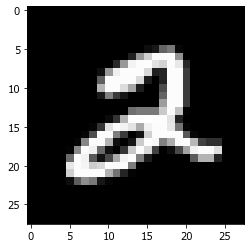

In [10]:
# show the 6th image in x_train
show_image(x_train,5)

Now that we've coded all our functions, we shall preprocess our data to input into our neural network

In [77]:
x_train_input = flatten_and_normalize(x_train)
y_train_input,mapping = preprocess_y(y_train)
print('X_train dimensions:',x_train_input.shape)
print('Y_train dimensions:',y_train_input.shape)

X_train dimensions: (784, 60000)
Y_train dimensions: (10, 60000)


I have already trained my network for about 1.5 hours and saved my parameters. We shall load these trained parameters for prediction.

In [78]:
mnist_params = open_params("MNIST_params_12000.pickle")
cat_params = open_params("catvsnoncat_params_2400.pickle")

You can start training the network using the nn_model function. I trained the network for 12000 epochs on the MNIST dataset to get my parameters mnist_params. Total training time was around 1.5 hours.

In [55]:
final_params = nn_model(x_train_input,y_train_input,n_hidden = [50,20],activation = 'relu',alpha=0.003,epochs=2400)

Epoch  0 : Cost =  0.6645060697135088
Epoch  100 : Cost =  0.5451612180169071
Epoch  200 : Cost =  0.4649588330186332
Epoch  300 : Cost =  0.3955263459939174
Epoch  400 : Cost =  0.33551329910614913
Epoch  500 : Cost =  0.292495594957442
Epoch  600 : Cost =  0.2549141938365787
Epoch  700 : Cost =  0.2174846576171648
Epoch  800 : Cost =  0.19301048329010767
Epoch  900 : Cost =  0.13960675792042293
Epoch  1000 : Cost =  0.1105245320052982
Epoch  1100 : Cost =  0.09475257003169259
Epoch  1200 : Cost =  0.07453093628158868
Epoch  1300 : Cost =  0.06378998272510761
Epoch  1400 : Cost =  0.054119056822700656
Epoch  1500 : Cost =  0.046483447051926266
Epoch  1600 : Cost =  0.04051600999066786
Epoch  1700 : Cost =  0.03553816025986224
Epoch  1800 : Cost =  0.03146131443280601
Epoch  1900 : Cost =  0.027929278844826315
Epoch  2000 : Cost =  0.025034966971407585
Epoch  2100 : Cost =  0.022549110461506018
Epoch  2200 : Cost =  0.020427826686482516
Epoch  2300 : Cost =  0.01861373805494785


We shall use our loaded parameter sets mnist_params and cat_params for prediction

In [79]:
y_test_input,mapping_test = preprocess_y(y_test)
x_test_input = flatten_and_normalize(x_test)
preds = predict(x_train_input,mnist_params)
preds_test = predict(x_test_input,mnist_params)
print('Training data accuracy:',accuracy(preds,y_train))
print('Test data accuracy:',accuracy(preds_test,y_test))

Training data accuracy: 95.76833333333333
Test data accuracy: 95.28999999999999


Using the mnist_params set, we get a training accuracy of 95.76% and a testing accuracy of 95.28% on the MNIST dataset, which seems quite good. Convolutional neural networks can get to even higher accuracies due to their ability to detect edges and patterns in multiple areas of the image.

Using the classify_instance function, you can visualize and even predict individual examples from the testing or training sets.

The predicted class is  5


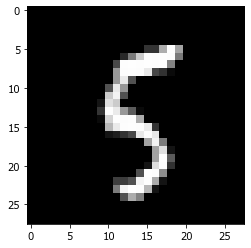

In [84]:
# second argument is the image number
classify_instance(x_test,1879,mnist_params)

In [60]:
#save_params(final_params,"catvsnoncat_params_2400.pickle")